<img src="https://i.postimg.cc/R0qN7VJy/1.jpg" alt="Flowers" class="center">

**In this notebook i will experiment transfer learning from 8 most popular pre trained convolutional neural networks for identify the type of flowers in a dataset of images (for simplicity, we’re sticking to just over 100 types).**

**I will made an assemblage using this 8 architectures by creating fair voting system between them, at the end every CNN architecture will return type of flower and i will considertate the choice of the majority.**

**Fair play =)**

**I will take advantage of the powerful Tensor Processing Units (TPUs) provided by Kaggle in cloud, it allows to greatly increase the learning speed and also it pushes the limits of RAM as what happens for gpu which allows to consider high resolution images.**

**i will also do data augmentation on pictures by zoom, rotate, inverse, shift and share them. it decrease overfitting.**

**Pretrained models used for voting :**

* Xception
* VGG16
* DenseNet201
* InceptionV3
* EfficientNetB7
* ResNet152V2
* MobileNetV2
* InceptionResNetV2

<a href="https://keras.io/api/applications/">Keras reference</a>

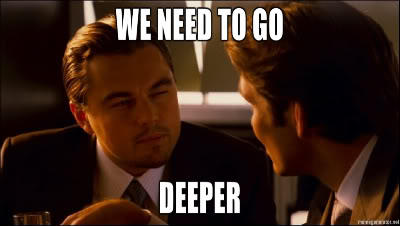

**Referances :**

<a href="https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96">Rotation Augmentation GPU/TPU - [0.96+]</a>

<a href="https://www.kaggle.com/sgladysh/flowers-tpu-efficientnet-b7-b6-b5-b4">Flowers@TPU EfficientNet B7+B6+B5+B4</a>

<a href="https://www.kaggle.com/philculliton/a-simple-petals-tf-2-2-notebook">A Simple Petals TF 2.2 notebook</a>

## Solution Architecture

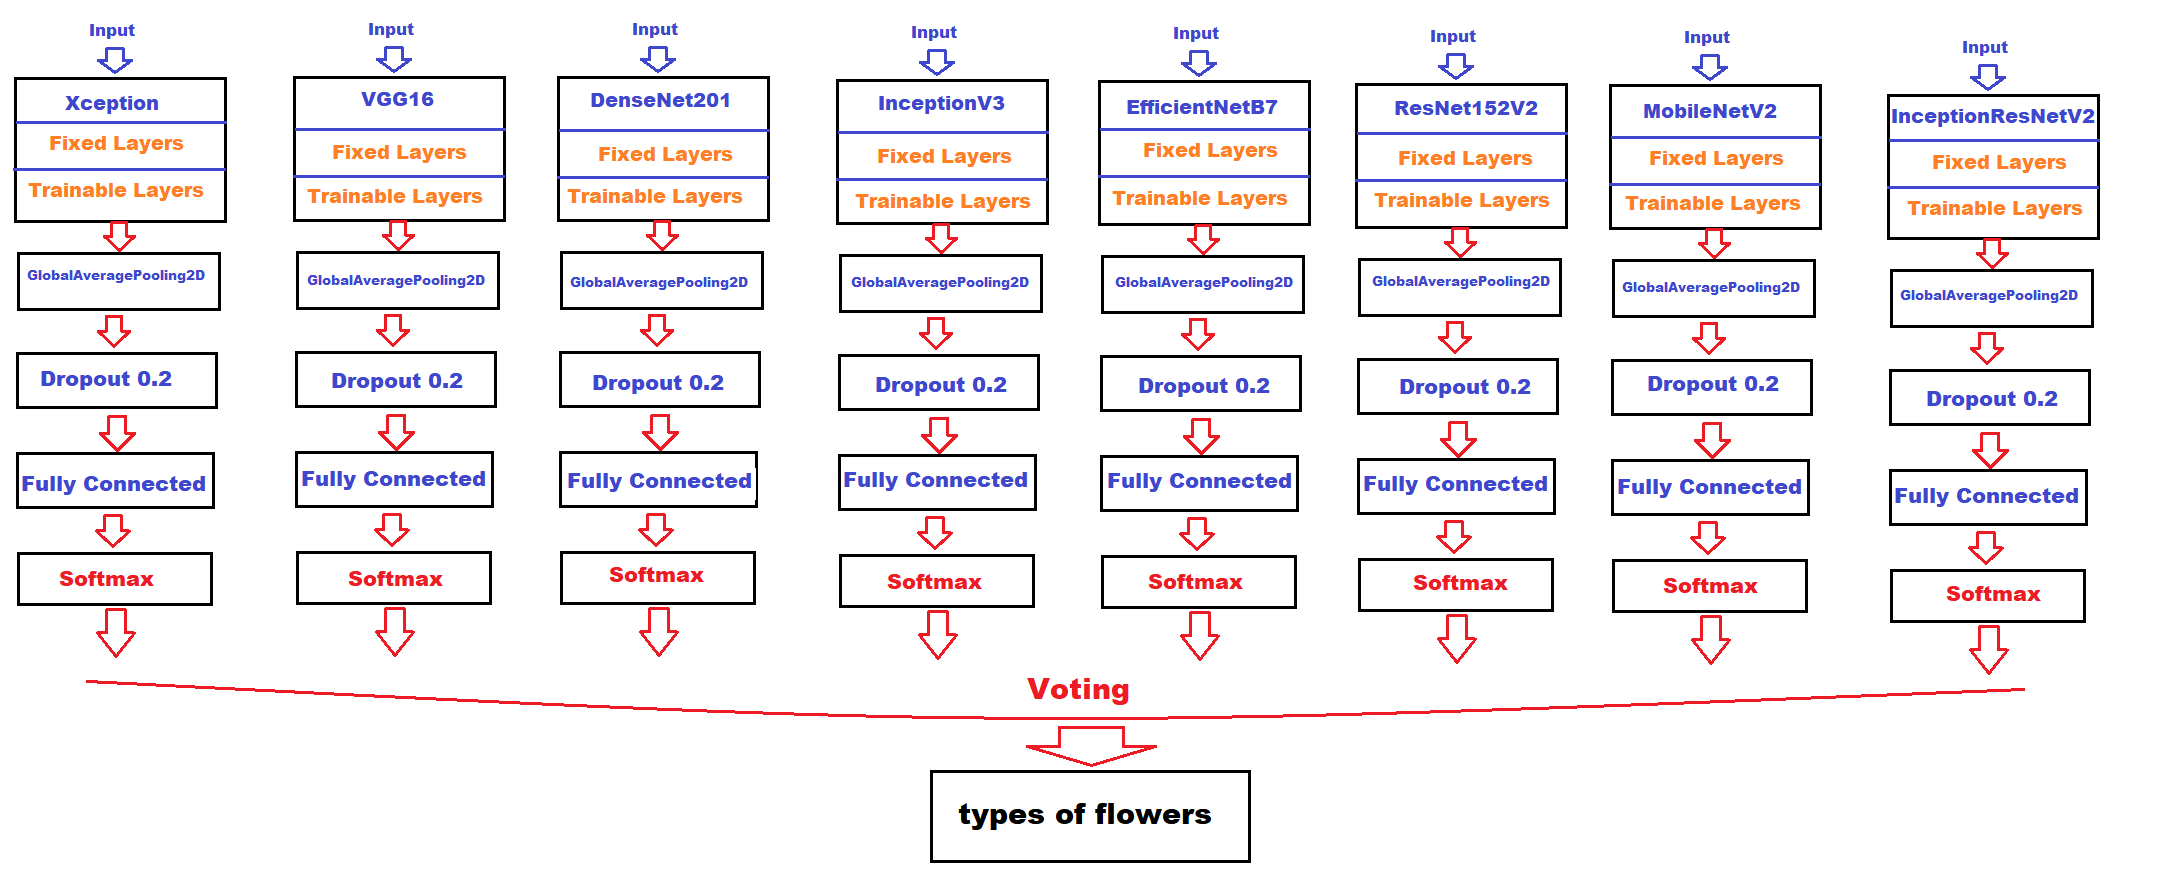

**<p style="color:red">If you like this approach please Upvote it will motivate me to continue =D Enjoy.</p>**

# Contents

* [<font size=4>1. Libraries</font>](#1)
* [<font size=4>2. Configuration and Data Access</font>](#2)
* [<font size=4>3. Data Augmentation</font>](#3)
* [<font size=4>4. Pretrained Models Creation</font>](#4)
* [<font size=4>5. Transfer Learning and Prediction</font>](#5)
 *     [Apply voting to all models output](#5.1)
* [<font size=4>6. Models Performance</font>](#6)
 *     [Accuracy / Loss Evolution](#6.1)
 *     [Confusion Matrix](#6.2)
* [<font size=4>7. Submit predictions</font>](#6)

# 1. Libraries <a id="1"></a>

In [ ]:
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf, tensorflow.keras.backend as K
from kaggle_datasets import KaggleDatasets
from IPython.display import Image
from tensorflow.keras.utils import plot_model
print('Tensorflow version ' + tf.__version__)
from sklearn.model_selection import KFold
import gc
from scipy import stats
import gc
from collections import Counter

!pip install -q efficientnet

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionV3
from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

# 2. Configuration and Data Access <a id="2"></a>

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
IMAGE_SIZE = [224, 224]
EPOCHS = 30
FOLDS = 3
SEED = 777
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [ ]:
MIXED_PRECISION = False
XLA_ACCELERATE = False

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

In [ ]:
# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

TRAINING_FILENAMES_ONLY = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VAL_FILENAMES_ONLY =  tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']   


# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

    
def scheduler(epoch):
    if epoch < 4:
        return 0.0005
    elif epoch < 8:
        return 0.0002
    elif epoch < 12:
        return 0.0001
    elif epoch < 16:
        return 0.00005
    elif epoch < 20:
        return 0.00002
    else:
        return 0.00001
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [scheduler(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))



In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset,do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# 3. Data Augmentation <a id="3"></a>

Big Thanks to Chris Deotte for this

<a href="https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96">Rotation Augmentation GPU/TPU - [0.96+]</a>

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [ ]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [ ]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [ ]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [ ]:
row = 3; col = 4;
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
one_element = tf.data.Dataset.from_tensors( next(iter(all_elements)) )
augmented_element = one_element.repeat().map(transform).batch(row*col)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# 4. Pretrained Models Creation <a id="4"></a>

In [ ]:
# Create Test, TRain and validation Data

train_dataset_all = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES})['TRAINING_FILENAMES']), labeled = True)
test_dataset_all = load_dataset(list(pd.DataFrame({'TEST_FILENAMES': TEST_FILENAMES})['TEST_FILENAMES']), labeled = True, ordered=True)

train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES_ONLY': TRAINING_FILENAMES_ONLY})['TRAINING_FILENAMES_ONLY']), labeled = True)
val_dataset = load_dataset(list(pd.DataFrame({'VAL_FILENAMES_ONLY': VAL_FILENAMES_ONLY})['VAL_FILENAMES_ONLY']), labeled=True, ordered=True)


train_all = get_training_dataset(train_dataset_all) #Both validation and train concatenated for final fitting
test = get_test_dataset(test_dataset_all)
test_images_ds = test.map(lambda image, idnum: image)

train = get_training_dataset(train_dataset)
val = get_validation_dataset(val_dataset)

def Xception_model():
    with strategy.scope():
        rnet = Xception(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def VGG16_model():
    with strategy.scope():
        rnet = VGG16(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def DenseNet201_model():
    with strategy.scope():
        rnet = DenseNet201(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def InceptionV3_model():
    with strategy.scope():
        rnet = InceptionV3(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def EfficientNetB7_model():
    with strategy.scope():
        rnet = EfficientNetB7(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def ResNet152V2_model():
    with strategy.scope():
        rnet = ResNet152V2(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def MobileNetV2_model():
    with strategy.scope():
        rnet = MobileNetV2(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

def InceptionResNetV2_model():
    with strategy.scope():
        rnet = InceptionResNetV2(
            input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
            weights='imagenet',
            include_top=False
        )
        # trainable rnet
        rnet.trainable = True
        model = tf.keras.Sequential([
            rnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax',dtype='float32')
        ])
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

models = {
            'Xception' : Xception_model,
          'VGG16' : VGG16_model,
          'DenseNet201' : DenseNet201_model,
          'InceptionV3' : InceptionV3_model,
#          'EfficientNetB7' : EfficientNetB7_model, 
          'ResNet152V2' : ResNet152V2_model, 
          'MobileNetV2' : MobileNetV2_model, 
          'InceptionResNetV2' : InceptionResNetV2_model
         }
historys = {}
predictions = {}
predictions_val = {}
predictions_prob = {}

MODELS_NUMBER = 7 #By RAM constraints i took only 5 models

# 5. Transfer Learning and Prediction <a id="5"></a>

In [ ]:
for name, model_ in models.items() :
    print('Running ' + name)
    model = model_()
    plot_model(model, to_file= name+'.png', show_shapes=True)

    history = model.fit(
        train, 
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [lr_callback],#, early_stopping],
        validation_data = val,
        verbose = 3
    )
    historys[name] = history # Save historys
    predictions_val = np.argmax(model.predict(val), axis=-1)
#     Train on Train and validation Data for prediction
    del model
    gc.collect()

    model = model_()
    history = model.fit(
        train_all, 
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = EPOCHS,
        callbacks = [lr_callback],#, early_stopping],
        verbose = 2
    )
    
    predictions_prob[name] = model.predict_proba(test_images_ds)
    predictions[name] = np.argmax(model.predict(test_images_ds), axis=-1)

## Apply voting to all models output <a id="5.1"></a>

In [ ]:
df = pd.DataFrame(predictions)
pred = []
for i in range(0, 7382) :
    if df.loc[i,:].unique().shape[0] < MODELS_NUMBER :
        pred.append(stats.mode(df.loc[i,:].values)[0][0])
    else :
        pred.append(df.loc[i,'Xception'])
        
df = pd.DataFrame(predictions_val)
pred_val = []
for i in range(0, 3712) :
    if df.loc[i,:].unique().shape[0] < MODELS_NUMBER :
        pred_val.append(stats.mode(df.loc[i,:].values)[0][0])
    else :
        pred_val.append(df.loc[i,'Xception'])

In [ ]:
avg_prob = predictions_prob['Xception'] + predictions_prob['VGG16'] + predictions_prob['DenseNet201'] + predictions_prob['InceptionV3'] + predictions_prob['EfficientNetB7'] 
pred_avg = pd.DataFrame(np.argmax(avg_prob, axis=-1))

# 6. Models Performance <a id="6"></a>

## Accuracy / Loss Evolution <a id="6.1"></a>

In [ ]:
import matplotlib.image as mpimg

i = 1
fig = plt.figure(figsize = [20,20])
for name, history in historys.items() :
    
    plt.subplot(8, 3, i)
    i += 1
#     display(Image(filename=name+'.png') )
    img=mpimg.imread(name+'.png')
    plt.title(name + ' Architecture')
    plt.imshow(img)
    
    plt.subplot(8, 3, i)
    i += 1
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title(name + ' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
    plt.subplot(8, 3, i)
    i += 1
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    
plt.tight_layout()

## Confusion Matrix <a id="6.2"></a>

Inspired from <a href="https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu">Getting started with 100+ flowers on TPU</a>


In [ ]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(45,45))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 18})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = "EfficientNet B7 with noisy-student weights"
    if score is not None:
        titlestring += '\n f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\n precision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\n recall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 30, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

cmdataset = val
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() 
# cm_probabilities = model1.predict(images_ds)
cm_predictions = pred_val
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T 
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

Models Voting seems perform well =)

## 7. Submit predictions <a id="7"></a>

In [ ]:
test_ids_ds = test.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission_vote.csv', np.rec.fromarrays([test_ids, pred]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, np.argmax(avg_prob, axis=-1)]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

 <FONT size="5pt"><p style="color:red">If you like this approach please Upvote it will motivate me to continue =D, I hope you Enjoyed ;-)</p></FONT>